**Note:** The following section demonstrates a very basic, proportional-risk approach to allocating officer hours across wards.  
This method is **not** used in the final model.

For the detailed allocation methodology, see the “Resource Allocation” section later in this notebook.

In [5]:
import pandas as pd
import numpy as np


df_lsoa = pd.read_parquet("../data/processed/census_lsoa.parquet")
lookup = pd.read_csv(
    "../data/lookups/look up LSOA 2021 to ward 2024 merged.csv",
    usecols=["LSOA21CD", "WD24CD", "WD24NM"]
)

# Mege on LSOA code
df_lsoa = df_lsoa.merge(
    lookup,
    left_on="LSOA code",
    right_on="LSOA21CD",
    how="inner"
)
df_ward_census = (
    df_lsoa
    .groupby(["WD24CD", "WD24NM"], as_index=False)
    .agg({"Total: All dwellings": "sum"})
)
df_ward_census.rename(
    columns={
        "WD24CD": "Ward code",
        "WD24NM": "Ward name",
        "Total: All dwellings": "Dwellings"
    },
    inplace=True
)

# Load prediction Data
sarima_fc = pd.read_csv(
    "../data/processed/sarima_final_forecast_per_ward.csv",
    parse_dates=["Month"]
)
first_fc_month = sarima_fc["Month"].min()
fc1 = sarima_fc[sarima_fc["Month"] == first_fc_month].copy()

df = (
    fc1[["Ward code", "Ward name", "mean"]]
    .merge(
        df_ward_census[["Ward code", "Dwellings"]],
        on="Ward code",
        how="left"
    )
    .rename(columns={"mean": "Forecasted_Burglaries"})
)

df["Risk_Rate"] = df["Forecasted_Burglaries"] / df["Dwellings"].replace(0, np.nan)
df["Risk_Rate"] = df["Risk_Rate"].clip(lower=0)

r_max = df["Risk_Rate"].max()

df["Allocated_Hours"] = 200 * (df["Risk_Rate"] / r_max)
df["Allocated_Hours"] = df["Allocated_Hours"].clip(lower=2)

df["Allocated_Hours"] = df["Allocated_Hours"].round(0) # Integer hours
df = df.sort_values("Allocated_Hours", ascending=False).reset_index(drop=True)

print(df[[
    "Ward code",
    "Ward name",
    "Dwellings",
    "Risk_Rate",
    "Allocated_Hours"
]])

df.to_csv("../data/processed/ward_hour_allocation.csv", index=False)


     Ward code                 Ward name  Dwellings     Risk_Rate  \
0    E05013662   Holborn & Covent Garden       5985  4.385889e-03   
1    E05013748     Shepherd's Bush Green       3080  4.309465e-03   
2    E09000001            City of London       7330  3.821007e-03   
3    E05009377  Hoxton East & Shoreditch       6410  3.821176e-03   
4    E05013808                  West End      10270  3.786360e-03   
..         ...                       ...        ...           ...   
675  E05009368                  Cazenove       5300  0.000000e+00   
676  E05013883                   Cathall       4310  0.000000e+00   
677  E05013945                  Tolworth       4755  4.669708e-19   
678  E05013578             Ruislip Manor       3920  0.000000e+00   
679  E05013617            Heston Central       4485  0.000000e+00   

     Allocated_Hours  
0              200.0  
1              197.0  
2              174.0  
3              174.0  
4              173.0  
..               ...  
675       

**Resource Allocation method**

In [1]:
import pandas as pd
from gurobipy import Model, GRB

# Load the simple-method total
allocation_simple = pd.read_csv("../data/processed/ward_hour_allocation.csv")
total_officers_hours = allocation_simple["Allocated_Hours"].sum()

# Load SARIMA forecasts - first month
fc = pd.read_csv("../data/processed/sarima_final_forecast_per_ward.csv", parse_dates=["Month"])
first_month = fc["Month"].min()
forecast_df = (
    fc[fc["Month"] == first_month]
    [["Ward code","Ward name","mean"]]
    .rename(columns={"mean":"Predicted_Crime_Count"})
    .reset_index(drop=True)
)

demand = forecast_df["Predicted_Crime_Count"].tolist()
n = len(demand)

m = Model("ward_allocation_with_fixed_min")
m.Params.OutputFlag = 1

# Create variables: wards with d ≤ 0 are fixed at 2 -  others between 2 and 200
x = []
for i, d in enumerate(demand):
    if d <= 0:
        xi = m.addVar(lb=2.0, ub=2.0, name=f"x_{i}")
    else:
        xi = m.addVar(lb=2.0, ub=200.0, name=f"x_{i}")
    x.append(xi)

# a ≥ 0
alpha = m.addVar(lb=0.0, name="alpha")

# Add coverage constraints only for positive demand
for i, d in enumerate(demand):
    if d > 0:
        m.addConstr(x[i] >= d * alpha, name=f"cover_{i}")

# Add constraints
m.addConstr(sum(x) <= total_officers_hours, name="total_budget")

# Objective maximize a
m.setObjective(alpha, GRB.MAXIMIZE)
m.optimize()

# Extract
if m.status == GRB.Status.OPTIMAL:
    alpha_val = alpha.X
    allocated_continuous = [xi.X for xi in x]
    allocated_rounded  = [int(round(val)) for val in allocated_continuous]

    forecast_df["Alpha (Coverage Factor)"] = alpha_val
    forecast_df["Allocated_Officers_Continuous"] = allocated_continuous
    forecast_df["Allocated_Officers_Rounded"] = allocated_rounded

    # Sort and save
    forecast_df = forecast_df.sort_values("Allocated_Officers_Rounded", ascending=False)
    forecast_df.to_csv("../data/processed/ward_hour_allocation_LP_method.csv", index=False)
    print("Saved LP allocations to ward_hour_allocation_LP_method.csv")
else:
    print(f"Optimization ended with status {m.status}")

Restricted license - for non-production use only - expires 2026-11-23
Set parameter OutputFlag to value 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 669 rows, 681 columns and 2015 nonzeros
Model fingerprint: 0xf82adf89
Coefficient statistics:
  Matrix range     [2e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 2e+02]
  RHS range        [3e+04, 3e+04]
Presolve removed 6 rows and 18 columns
Presolve time: 0.02s
Presolved: 663 rows, 663 columns, 1986 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3112339e+02   6.082180e+04   0.000000e+00      0s
     662    5.1432496e+00   0.000000e+00   0.000000e+00      0s

Solved in 662 iter

**Comparison of Simple vs Linear Programming Allocation Methods**

C:\Users\20234582\AppData\Local\Temp\ipykernel_10716\1894517729.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


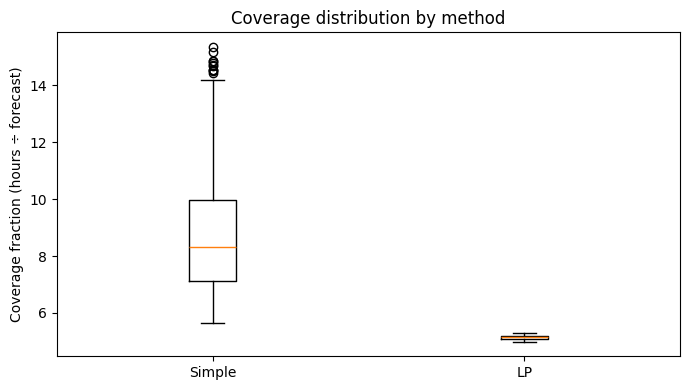

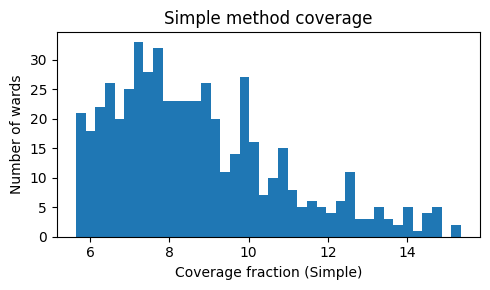

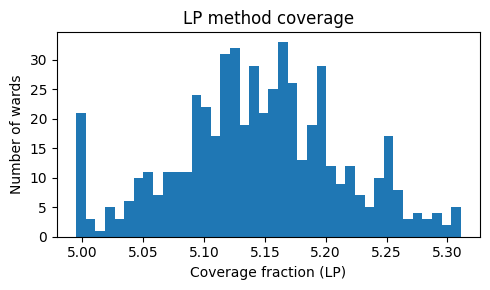

Coverage statistics:
  Minimum coverage -> Simple: 3.78, LP: 4.42
  Median coverage -> Simple: 8.41, LP: 5.15
  25th–75th percentile -> Simple: [7.04, 10.39], LP: [5.10, 5.20
  95th percentile (tail) -> Simple: 15.38, LP: 5.31


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
simple = pd.read_csv("../data/processed/ward_hour_allocation.csv")
lp = pd.read_csv("../data/processed/ward_hour_allocation_LP_method.csv")

fc = pd.read_csv("../data/processed/sarima_final_forecast_per_ward.csv", parse_dates=["Month"])
first_month = fc["Month"].min()
fc1 = (
    fc[fc["Month"] == first_month][["Ward code", "mean"]]
      .rename(columns={"mean": "Forecasted_Burglaries"})
)

# Merge all
df = (
    simple[["Ward code", "Allocated_Hours"]]
      .rename(columns={"Allocated_Hours": "Simple_Hours"})
      .merge(
          lp[["Ward code", "Allocated_Officers_Rounded"]]
            .rename(columns={"Allocated_Officers_Rounded": "LP_Hours"}),
          on="Ward code", how="inner"
      )
      .merge(fc1, on="Ward code", how="left")
)

# Coverage fractions
df["cov_simple"] = df["Simple_Hours"] / df["Forecasted_Burglaries"]
df["cov_lp"] = df["LP_Hours"] / df["Forecasted_Burglaries"]

# Clean
df = df[df["Forecasted_Burglaries"] > 0]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["cov_simple","cov_lp"])

# Trim extremes
quantiles = df[["cov_simple", "cov_lp"]].quantile([0.05, 0.95])
mask = (
    df["cov_simple"].between(quantiles.loc[0.05, "cov_simple"], quantiles.loc[0.95, "cov_simple"]) &
    df["cov_lp"].between(quantiles.loc[0.05, "cov_lp"], quantiles.loc[0.95, "cov_lp"])
)
df_trim = df[mask]

# Boxplot
plt.figure(figsize=(7,4))
plt.boxplot(
    [df_trim["cov_simple"], df_trim["cov_lp"]],
    labels=["Simple", "LP"]
)
plt.ylabel("Coverage fraction (hours ÷ forecast)")
plt.title("Coverage distribution by method")
plt.tight_layout()
plt.show()

# Histograms
methods = {
    "Simple": df_trim["cov_simple"],
    "LP": df_trim["cov_lp"],
}
for method, data in methods.items():
    plt.figure(figsize=(5,3))
    plt.hist(data, bins=40)
    plt.xlabel(f"Coverage fraction ({method})")
    plt.ylabel("Number of wards")
    plt.title(f"{method} method coverage")
    plt.tight_layout()
    plt.show()

# Statistics
min_simple = df["cov_simple"].min()
min_lp = df["cov_lp"].min()

median_simple = df["cov_simple"].median()
median_lp = df["cov_lp"].median()

q25_simple, q75_simple = df["cov_simple"].quantile([0.25, 0.75])
q25_lp, q75_lp = df["cov_lp"].quantile([0.25, 0.75])

p95_simple = df["cov_simple"].quantile(0.95)
p95_lp = df["cov_lp"].quantile(0.95)

print("Coverage statistics:")
print(f"  Minimum coverage -> Simple: {min_simple:.2f}, LP: {min_lp:.2f}")
print(f"  Median coverage -> Simple: {median_simple:.2f}, LP: {median_lp:.2f}")
print(f"  25th–75th percentile -> Simple: [{q25_simple:.2f}, {q75_simple:.2f}], LP: [{q25_lp:.2f}, {q75_lp:.2f}")
print(f"  95th percentile (tail) -> Simple: {p95_simple:.2f}, LP: {p95_lp:.2f}")
